To do:

[ ] licentie toevoegen

[ ] introductie toevoegen

[ ] vermogen in plots smoothen

[ ] ...

# De Perfecte Training Ontwerpen
## Op basis van critical power

Licentie van code en afbeeldingen definiëren.

Introductie over dit document.

## Import statements and other initialization

In [51]:
from athletic_pandas.models import Athlete, WorkoutDataFrame
from goldencheetahlib.client import GoldenCheetahClient
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [181]:
ARTICLE_ROOT_DIRECTORY = 'sportgericht/'

## Power Duration Models

In [42]:
time_axis = range(1, 600)
pd_data = pd.DataFrame(
    dict(
        critical_power=[300]*len(time_axis),
        power_duration_curve=[20000/t + 300 for t in time_axis]
    ),
    index=time_axis
)

Text(0,0.5,'vermogen (W)')

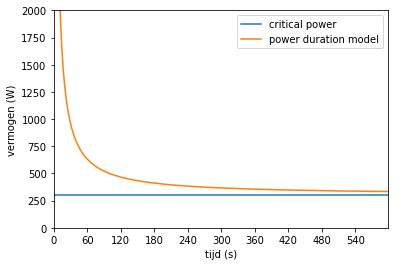

In [47]:
ax = pd_data.plot(ylim=(0,2000), xticks=range(0, 600, 60))
ax.legend(["critical power", "power duration model"]);
ax.set_xlabel('tijd (s)')
ax.set_ylabel('vermogen (W)')

## W'bal in de praktijk

### Eerste voorbeeld: 20-minuten test

In [195]:
# De volgende code is alleen nodig als je de trainingsdata direct uit de GoldenCheetah REST API wilt halen
# gc_client = GoldenCheetahClient('Aart')
# wdf = gc_client._request_activity_data('Aart', '2017_08_08_18_04_50.json')
# wdf = wdf.set_index(wdf.index.seconds)
# wdf.athlete = Athlete(cp=315, w_prime=18000)
# wdf = wdf.assign(w_bal=np.array(wdf.w_prime_balance()))
# cropped_wdf = wdf[1700:3000]
# cropped_wdf.to_json('20_minute_test.json')
# ...anders kun je de data ook gewoon vanuit het '20_minute_test.json'-bestand laden met het code-blok hieronder.

In [ ]:
wdf = WorkoutDataFrame(pd.read_json('20_minute_test.json'))
wdf.athlete = Athlete(cp=315, w_prime=18000)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11c8bbef0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x114819cc0>], dtype=object)

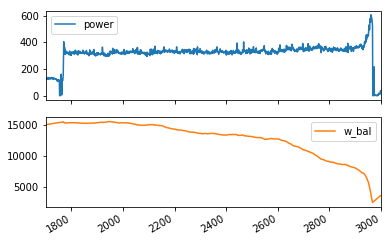

In [197]:
wdf.loc[:, ['power', 'w_bal']].plot(subplots=True)

### Tweede voorbeeld: intervaltraining

In [220]:
# De volgende code is alleen nodig als je de trainingsdata direct uit de GoldenCheetah REST API wilt halen
# gc_client = GoldenCheetahClient('Aart')
# wdf = gc_client._request_activity_data('Aart', '2017_10_11_18_11_37.json')
# wdf = wdf.set_index(wdf.index.seconds)
# wdf.athlete = Athlete(cp=315, w_prime=18000)
# wdf = wdf.assign(w_bal=np.array(wdf.w_prime_balance()))
# cropped_wdf = wdf[1200:]
# cropped_wdf.to_json('interval_training.json')
# ...anders kun je de data ook gewoon vanuit het '20_minute_test.json'-bestand laden met het code-blok hieronder.

In [221]:
wdf = WorkoutDataFrame(pd.read_json('interval_training.json'))
wdf.athlete = Athlete(cp=315, w_prime=18000)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11ce84a90>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11d51a898>], dtype=object)

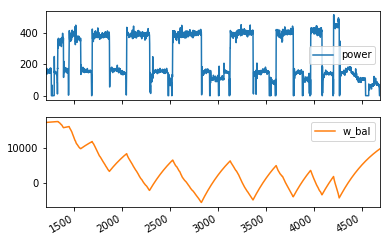

In [223]:
wdf.loc[:, ['power', 'w_bal']].plot(subplots=True)

## Trainingen Ontwerpen

### Casus 1

In [275]:
athlete = Athlete(cp=300, w_prime=20000)

def vermogen_casus_1(vermogen):
    warming_up = [100]*600
    interval = ([vermogen]*60 + [0]*60)*5
    rust = [0]*240
    cooling_down = [100]*600
    return warming_up + interval + rust + interval + rust + interval + cooling_down

wdf = WorkoutDataFrame()
wdf.athlete = athlete

wdf = wdf.assign(power=vermogen_casus_1(350))
wdf = wdf.assign(w_bal_350=wdf.w_prime_balance())

wdf = wdf.assign(power=vermogen_casus_1(365))
wdf = wdf.assign(w_bal_365=wdf.w_prime_balance())

wdf = wdf.assign(power=vermogen_casus_1(380))
wdf = wdf.assign(w_bal_380=wdf.w_prime_balance())

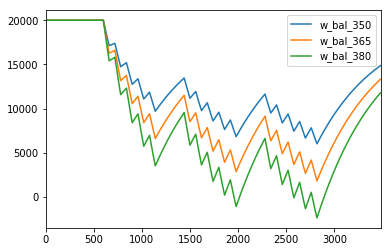

In [276]:
wdf.loc[:, ['w_bal_350', 'w_bal_365', 'w_bal_380']].plot(subplots=False)

In [277]:
for i in ['350', '365', '380']:
    min_w_bal = getattr(wdf, 'w_bal_'+i).min()
    print('Minimale W\'bal voor {vermogen}W: {min_w_bal}J ({perc}%)'.format(
        vermogen=i,
        min_w_bal=round(min_w_bal),
        perc=round(min_w_bal/athlete.w_prime*100, 1)
    ))

Minimale W'bal voor 350W: 6014.0J (30.1%)
Minimale W'bal voor 365W: 1819.0J (9.1%)
Minimale W'bal voor 380W: -2377.0J (-11.9%)


### Casus 2

In [355]:
athlete = Athlete(cp=300, w_prime=20000)
vo2_vermogen = athlete.cp + athlete.w_prime/(8*60)

def vermogen_casus_2(rust_lengte):
    warming_up = [100]*600
    interval = [vo2_vermogen]*300
    rust = [0]*rust_lengte
    cooling_down = [100]*600
    return warming_up + interval + rust + interval + rust + interval + rust + interval + cooling_down

short = 300
long = 720

wdf = WorkoutDataFrame()
wdf.athlete = athlete
wdf = wdf.assign(power=vermogen_casus_2(short) + [0.]*(long-short)*3)
wdf = wdf.assign(w_bal_5m_rust=wdf.w_prime_balance())

wdf = wdf.assign(power=vermogen_casus_2(long))
wdf = wdf.assign(w_bal_12m_rust=wdf.w_prime_balance())

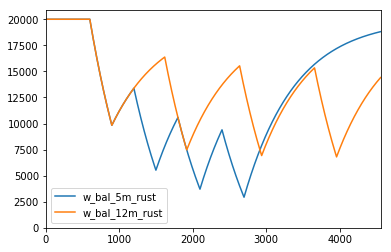

In [356]:
wdf.loc[:, ['w_bal_5m_rust', 'w_bal_12m_rust']].plot(ylim=0)

In [363]:
w_bal_voor_tweede_5m = wdf.w_bal_5m_rust[600 + 300 + 300]
print('W\'bal voorafgaand aan tweede interval bij 5 min rust: {w_bal}J ({perc}%)'.format(
        w_bal=round(w_bal_voor_tweede_5m),
        perc=round(w_bal_voor_tweede_5m/athlete.w_prime*100)
))

w_bal_voor_laatste_12m = wdf.w_bal_12m_rust[600 + 3*300 + 3*720]
print('W\'bal voorafgaand aan laatste interval bij 12 min rust: {w_bal}J ({perc}%)'.format(
        w_bal=round(w_bal_voor_laatste_12m),
        perc=round(w_bal_voor_laatste_12m/athlete.w_prime*100)
))

W'bal voorafgaand aan tweede interval bij 5 min rust: 13352.0J (67.0%)
W'bal voorafgaand aan laatste interval bij 12 min rust: 15305.0J (77.0%)


### Casus 3

In [398]:
athlete = Athlete(cp=300, w_prime=20000)

def vermogen_casus_3(rust_lengte):
    warming_up = [100]*600
    interval = [athlete.cp*1.40]*60
    rust = [0]*rust_lengte
    cooling_down = [100]*600
    return warming_up + (interval + rust)*8 + cooling_down

short = 120
middle = 240
long = 300

wdf = WorkoutDataFrame()
wdf.athlete = athlete
wdf = wdf.assign(power=vermogen_casus_3(short) + [0.]*((long-short)*8))
wdf = wdf.assign(w_bal_120=wdf.w_prime_balance())

wdf = wdf.assign(power=vermogen_casus_3(middle) + [0.]*((long-middle)*8))
wdf = wdf.assign(w_bal_240=wdf.w_prime_balance())

wdf = wdf.assign(power=vermogen_casus_3(long))
wdf = wdf.assign(w_bal_300=wdf.w_prime_balance())

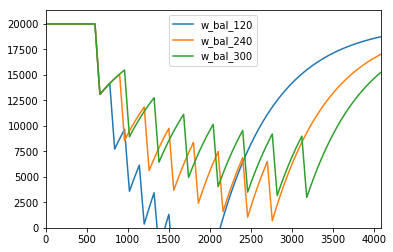

In [399]:
wdf.loc[:, ['w_bal_120', 'w_bal_240', 'w_bal_300']].plot(ylim=0)

In [400]:
for i in ['120', '240', '300']:
    min_w_bal = getattr(wdf, 'w_bal_'+i).min()
    print('Minimale W\'bal voor {rust} min rust: {min_w_bal}J ({perc}%)'.format(
        rust=int(int(i)/60),
        min_w_bal=round(min_w_bal),
        perc=round(min_w_bal/athlete.w_prime*100)
    ))

Minimale W'bal voor 2 min rust: -6729.0J (-34.0%)
Minimale W'bal voor 4 min rust: 689.0J (3.0%)
Minimale W'bal voor 5 min rust: 2979.0J (15.0%)
